In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify

### Parameters

In [313]:
N = 5                  # number of states in charge basis: -N...N
ν_ge = 5.5223             # atom frequency, GHz
Ec = 0.2
Ej = (ν_ge-Ec)**2/Ec/8  # see Koch's paper for the approximation of the ge transition frequency
Ej_fixed = (ν_ge+0.4-Ec)**2/Ec/8
Ej = Ej_fixed
dE_ghz = 2.5
dEj = dE_ghz/ν_ge              #Ej(t) = Ej*time_coeff(t,dEj)
f = 0.003
a = 68               #approximate start of Ej change
#t_gate1 = np.pi/f*coef*2
t_gate1 = 4000
b = a + t_gate1                 #approximate end of Ej change
a2 = 100000
t_gate2 = 40
b2 = a2 + t_gate2
stretch = 0.1            #stretch -> 0, time_coeff -> theta(t-t1) - theta(t-t2)
w = 1
#w = evals[1]-evals[0]
phase1 = 0
phase2 = 0
time_coeff = "0.5*(tanh((t-a)/st) - tanh((t-b*0-a)/st)+2)*cos(w*(t) + phase1) + 0.5*(tanh((t-a2)/st) - tanh((t-b2)/st))*cos(w*t + phase2)"
args = {'a':a,'b':b,'a2':a2,'b2':b2,'st':stretch,'w':w,'phase1':phase1,'phase2':phase2}
tlist_t = t_gate1+a*2
timesteps = 3000
tlist = np.linspace(0,tlist_t,timesteps)
gamma_m = 0.000          #collapse rate
print(Ej_fixed)

20.46544830625


### Visualize pulse

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


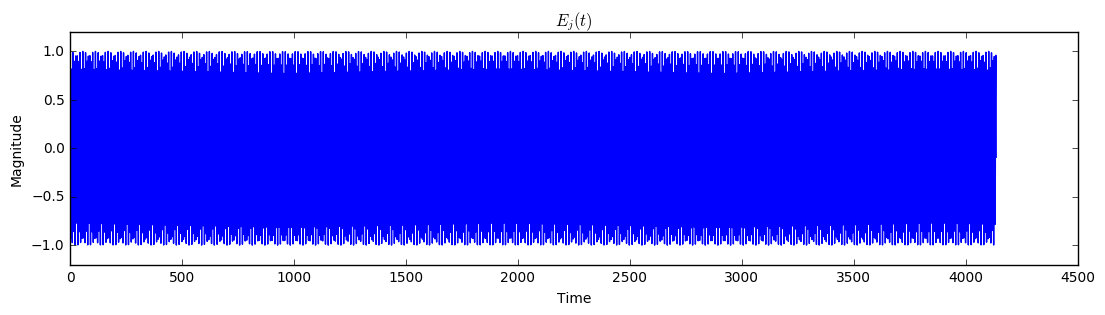

In [314]:
time_c_func = lambdify({'a','b','a2','b2','st','t','w','phase1','phase2'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=a,b=b,a2=a2,b2=b2,w=w,st=stretch,phase1=phase1,phase2=phase2,t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

In [284]:
def visualize_output(output):
    fig, axes = plt.subplots(3,1, figsize=(13,15), sharex=True)
    axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['0t','1t','2t']
    labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
    for idx, ax in enumerate(axes):
        ax.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.5,1.1)
        ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
        ax.set_xlabel('Time')
    axes[0].set_ylabel('Occupation probability')
def visualize_output2(output):
    fig, axes = plt.subplots(1,1, figsize=(13,5), sharex=True)
    axes.set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['0t','1t','2t']
    labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
    for idx in range(3):
        axes.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        axes.set_ylim(-1.5,1.1)
        axes.legend(bbox_to_anchor = [0,0],loc = "lower left")
        axes.set_xlabel('Time')
    axes.set_ylabel('Occupation probability')

### Operators definition

In [315]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def Hc(N_states = N, Ec = Ec, n_g = 0):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N, Ej = Ej):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N, Ej = Ej, Ec = Ec):
    return Hc(N_states,Ec) + Hj(N_states,Ej)
print(f)
def Hq_t(N_states = N,time_coeff = time_coeff, Ej = Ej, Ec = Ec):
    return [Hq(N_states),[n(N_states)*f, time_coeff]]

evals, evecs = Hq().eigenstates()
def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    if(gamma_m > 0):
        collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

def S_basis(evecs):
    S = [[el[0] for el in evec.data.toarray()] for evec in evecs ]
    return Qobj(S)
def convert_2toN(A2d,evecs):
    B2d = A2d.data.toarray()
    A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
    A[0][0] = B2d[0][0]
    A[0][1] = B2d[0][1]
    A[1][0] = B2d[1][0]
    A[1][1] = B2d[1][1]
    Aq = Qobj(A)
    return Aq.transform(evecs,True)
#convert_2toN(sigmax(),evecs)
psi0 = evecs[0]
print((evals[1]-evals[0]))
w = evals[1]-evals[0]
args['w']=w

0.003
5.52842157179


In [168]:
nn = n(N).transform(evecs)
nn

Quantum object: dims = [[11], [11]], shape = [11, 11], type = oper, isherm = True
Qobj data =
[[  0.00000000e+00  -1.31052972e+00   0.00000000e+00   3.40156054e-02
    0.00000000e+00   4.46081208e-03   0.00000000e+00   1.98691203e-03
    0.00000000e+00   1.42144347e-03   0.00000000e+00]
 [ -1.31052972e+00   0.00000000e+00  -1.80213773e+00   0.00000000e+00
   -7.74883619e-02   0.00000000e+00   1.46985189e-02   0.00000000e+00
   -6.36570792e-03   0.00000000e+00   6.13593301e-03]
 [  0.00000000e+00  -1.80213773e+00   0.00000000e+00   2.10907713e+00
    0.00000000e+00   1.36912528e-01   0.00000000e+00   3.39752132e-02
    0.00000000e+00   1.85188164e-02   0.00000000e+00]
 [  3.40156054e-02   0.00000000e+00   2.10907713e+00   0.00000000e+00
    2.27246917e+00   0.00000000e+00  -2.04203842e-01   0.00000000e+00
    6.00944268e-02   0.00000000e+00  -4.41489876e-02]
 [  0.00000000e+00  -7.74883619e-02   0.00000000e+00   2.27246917e+00
    0.00000000e+00   2.32055168e+00   0.00000000e+00   2.822

### Dynamics 

In [278]:
expected = []
for i in range(3):
        expected.append(evecs[i]*evecs[i].dag())
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [328]:
psi0 = (evecs[1] + evecs[0])/(2**0.5)
#psi0 = evecs[0]
expected = []
print(f)
output = solve(expected)
sxn = convert_2toN(sigmax(), evecs)
syn = convert_2toN(sigmay(), evecs)
szn = convert_2toN(sigmaz(), evecs)
#output2.expect.append([expect(sxn,state) for state in output.states])
#output2.expect.append([expect(syn,state) for state in output.states])
#output2.expect.append([expect(szn,state) for state in output.states])


0.003
10.0%. Run time:   1.30s. Est. time left: 00:00:00:11
20.0%. Run time:   2.59s. Est. time left: 00:00:00:10
30.0%. Run time:   3.86s. Est. time left: 00:00:00:09
40.0%. Run time:   5.12s. Est. time left: 00:00:00:07
50.0%. Run time:   6.38s. Est. time left: 00:00:00:06
60.0%. Run time:   7.66s. Est. time left: 00:00:00:05
70.0%. Run time:   8.96s. Est. time left: 00:00:00:03
80.0%. Run time:  10.26s. Est. time left: 00:00:00:02
90.0%. Run time:  11.56s. Est. time left: 00:00:00:01
Total run time:  12.87s


In [322]:
min(output2.expect[2])

-4.4147467787918017e-05

In [331]:
def rotatingFrame(output, expected_ops):
    output.expect = []
    for i in range(len(expected_ops)):
        output.expect.append([])
    szn = convert_2toN(sigmaz(), evecs)
    U = (-szn*1j*args['w']/2 * 0).expm()
    dt = tlist_t / (timesteps-1)
    dU = (-szn*1j*args['w']/2 * dt).expm()
    for time_step, state in enumerate(output.states):
        #time = dt * time_step
        U = U * dU
        Ud = U.dag()
        for i, eop in enumerate(expected_ops):
            output.expect[i].append(expect(Ud*eop*U, state))    
    return output
def rotatingFrame2(output, expected_ops):
    output.expect = []
    for i in range(len(expected_ops)):
        output.expect.append([])
    szn = convert_2toN(sigmaz(), evecs)
    U = (-1j*Hq()* 0).expm()
    dt = tlist_t / (timesteps-1)
    dU = (1j*Hq() * dt).expm()
    for time_step, state in enumerate(output.states):
        #time = dt * time_step
        U = U * dU
        Ud = U.dag()
        for i, eop in enumerate(expected_ops):
            output.expect[i].append(expect(Ud*eop*U, state))    
    return output

In [332]:
%%time
output2 = rotatingFrame2(output,[sxn,syn,szn])

CPU times: user 10.2 s, sys: 8 ms, total: 10.2 s
Wall time: 10.2 s


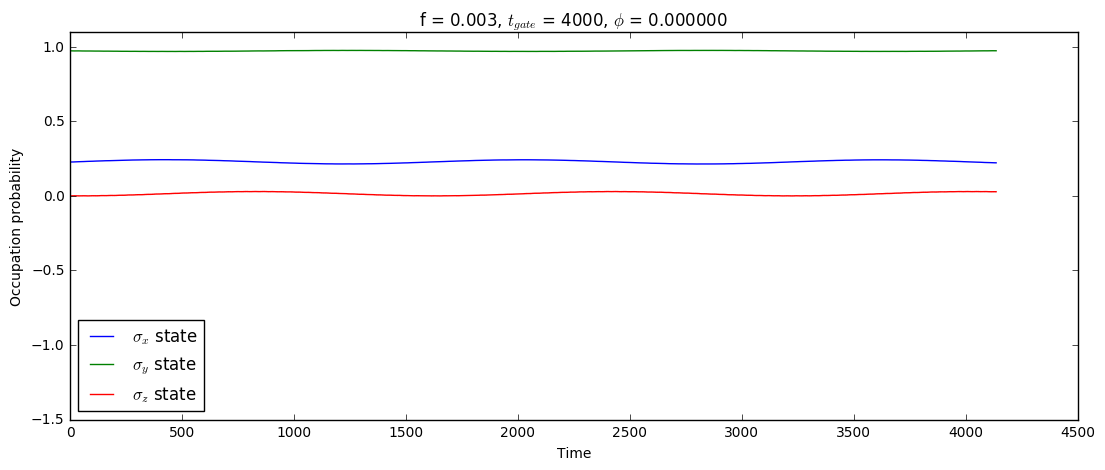

In [333]:
visualize_output2(output2)

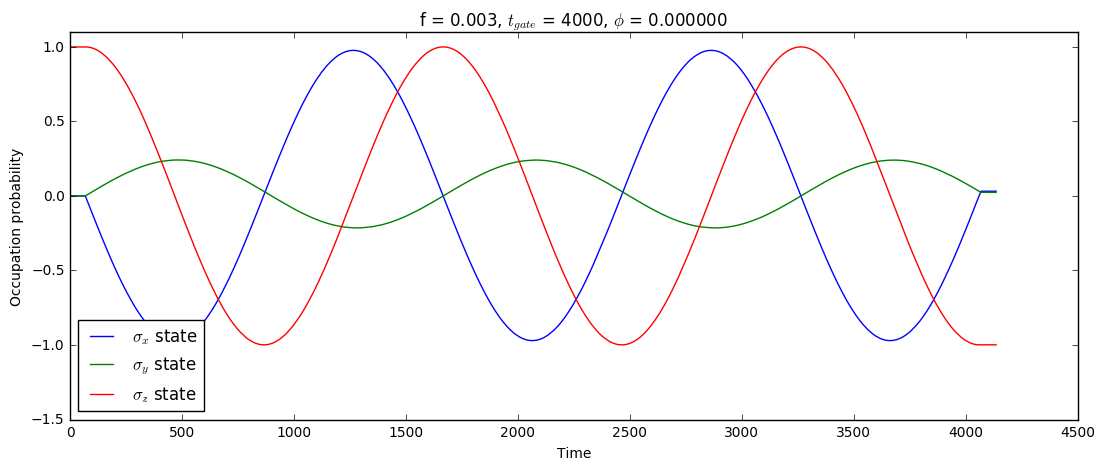

In [305]:
visualize_output2(output2)